In [3]:
setwd(paste0(Sys.getenv('R_SOURCES'), '/house_prices'))
source('main.R')


house_prices$helpers$import_libs()

combined_dataset <- house_prices$helpers$load_data()
training_dataset <- combined_dataset %>% filter(dataSource == 'train')

In [4]:
test_that("check some basic invariants", {
    
    combined_strange_cases <- house_prices$outliers$get_strange_cases(combined_dataset)
    combined_outliers_removed <- house_prices$outliers$remove_outliers(combined_dataset)
    
    training_strange_cases <- house_prices$outliers$get_strange_cases(training_dataset)
    training_outliers_removed <- house_prices$outliers$remove_outliers(training_dataset)

    expect_equal(nrow(combined_strange_cases) + nrow(combined_outliers_removed), nrow(combined_dataset))
    expect_equal(nrow(training_strange_cases) + nrow(training_outliers_removed), nrow(training_dataset))
    expect_equal(combined_strange_cases, training_strange_cases)
})

In [9]:
#
# SPDANM - deviation of price from neighborhood's median price
# price_per_sq - price per living area square feet
#
training_dataset <- 
    training_dataset %>%
    mutate(
        quality = case_when(
            OverallQual %in% c(1, 2, 3) ~ 'Bad',
            OverallQual %in% c(4, 5, 6) ~ 'Fair',
            OverallQual %in% c(7, 8)    ~ 'Good',
            TRUE                        ~ 'Excellent'
        ),
        price_per_sq = SalePrice / GrLivArea
    ) %>%
    group_by(Neighborhood) %>%
    mutate(
        SPDANM = SalePrice - median(SalePrice)
    )

strange_cases <- house_prices$outliers$get_strange_cases(training_dataset)
EdwardsExcellent <- training_dataset %>% filter(Neighborhood == 'Edwards', quality == 'Excellent')

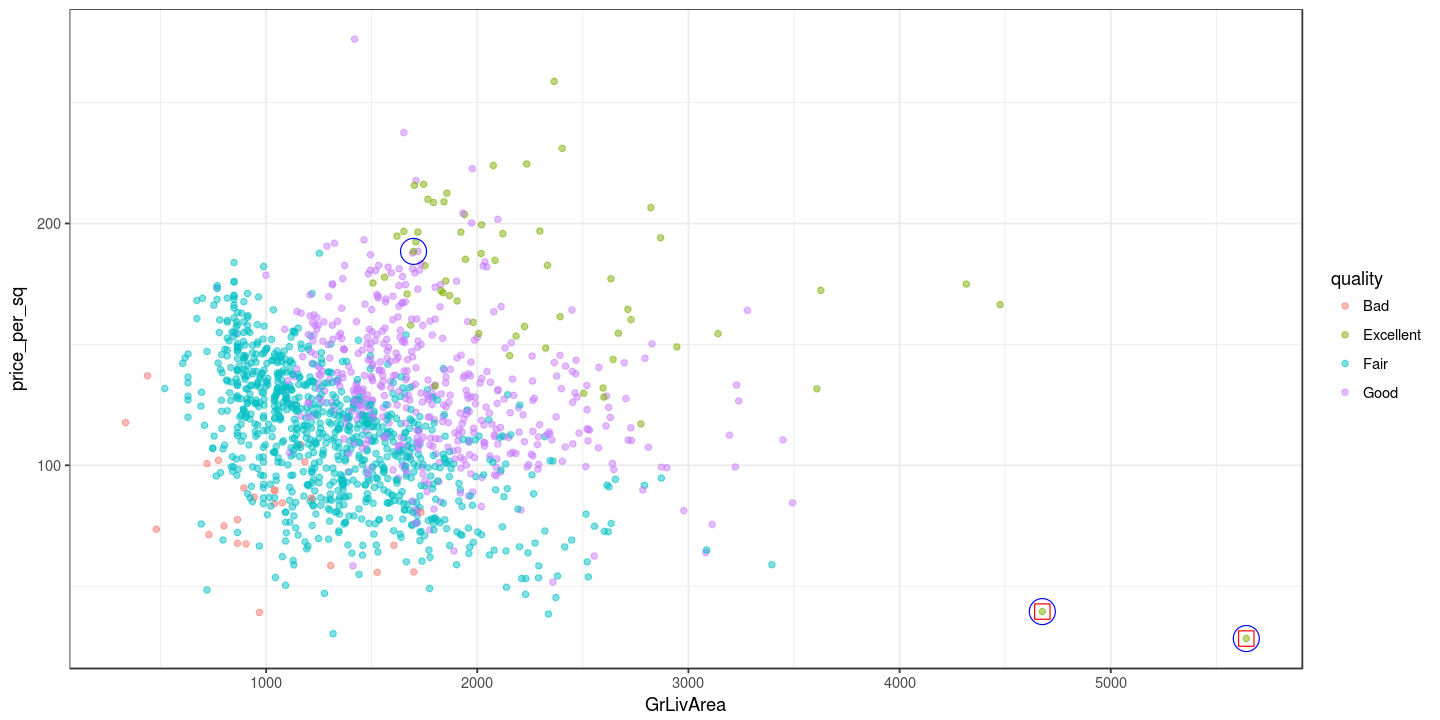

In [10]:
options(repr.plot.width = 12, repr.plot.height = 6)

training_dataset %>%
ggplot() +
geom_point(aes(x=GrLivArea, y=price_per_sq, color=quality), alpha=0.5) +
geom_point(data=strange_cases, aes(x=GrLivArea, y=price_per_sq), colour="red", size=4, shape=0) +
geom_point(data=EdwardsExcellent, aes(x=GrLivArea, y=price_per_sq), colour="blue", size=7, shape=1) +
theme_bw()

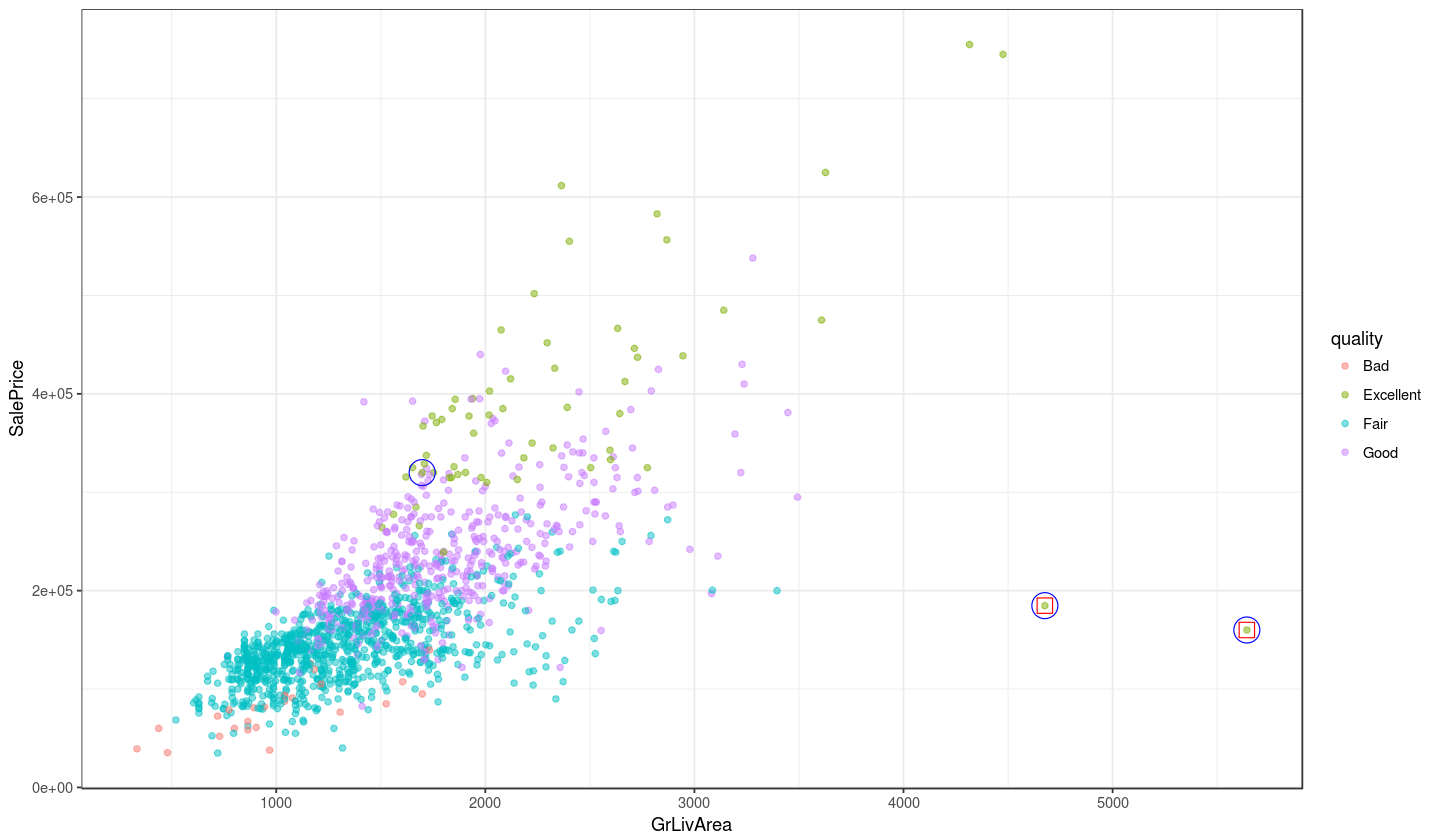

In [11]:
options(repr.plot.width = 12, repr.plot.height = 7)

training_dataset %>%
ggplot() +
geom_point(aes(x=GrLivArea, y=SalePrice, color=quality), alpha=0.5) +
geom_point(data=strange_cases, aes(x=GrLivArea, y=SalePrice), colour="red", size=4, shape=0) +
geom_point(data=EdwardsExcellent, aes(x=GrLivArea, y=SalePrice), colour="blue", size=7, shape=1) +
theme_bw()

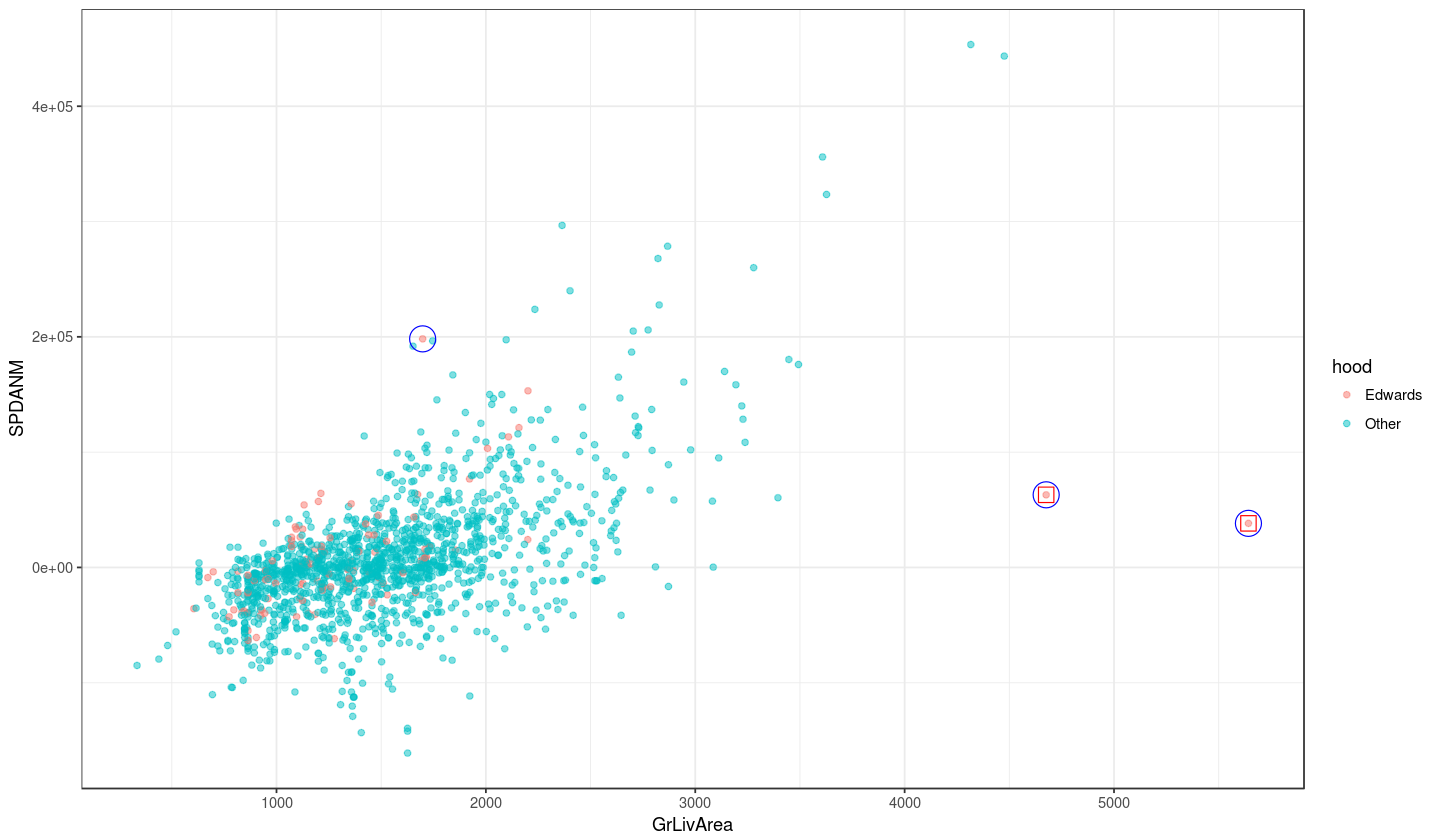

In [13]:
options(repr.plot.width = 12, repr.plot.height = 7)

training_dataset %>%
mutate(
    hood = ifelse(Neighborhood == 'Edwards', 'Edwards', 'Other')
) %>%
ggplot() +
geom_point(aes(x=GrLivArea, y=SPDANM, color=hood), alpha=0.5) +
geom_point(data=strange_cases, aes(x=GrLivArea, y=SPDANM), colour="red", size=4, shape=0) +
geom_point(data=EdwardsExcellent, aes(x=GrLivArea, y=SPDANM), colour="blue", size=7, shape=1) +
theme_bw()

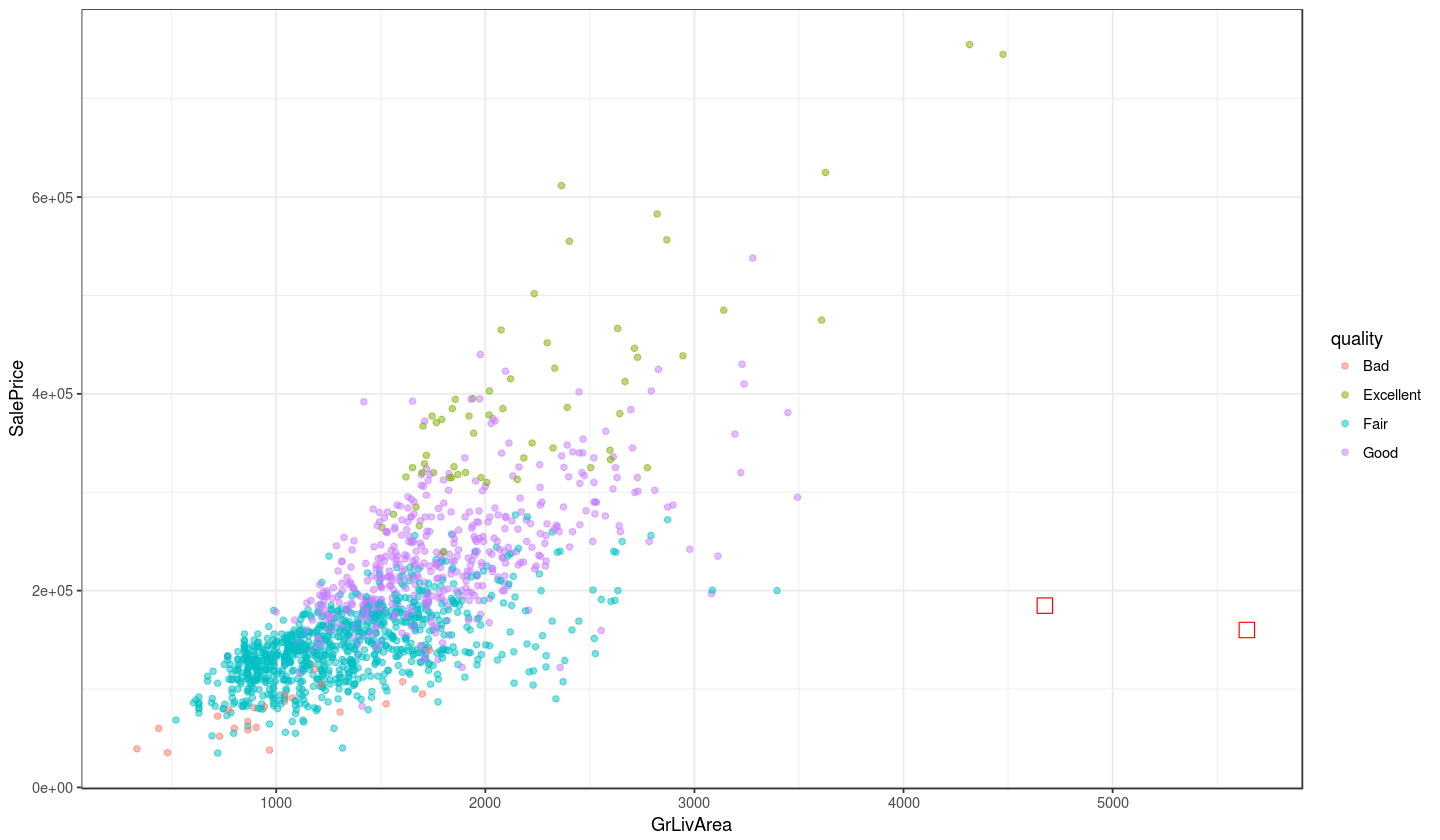

In [14]:
options(repr.plot.width = 12, repr.plot.height = 7)

training_dataset %>%
(house_prices$outliers$remove_outliers) %>%
ggplot() +
geom_point(aes(x=GrLivArea, y=SalePrice, color=quality), alpha=0.5) +
geom_point(data=strange_cases, aes(x=GrLivArea, y=SalePrice), colour="red", size=4, shape=0) +
theme_bw()